In [284]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [336]:
# 토콘화로 함수 정리 모카 자주쓰니까 나중에 이걸로 변경.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 문장 토큰화 및 ID 부여 함수
def preprocess(text):
    # 토큰화
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text])
    total_words = len(tokenizer.word_index) + 1
    
    word_to_id = tokenizer.word_index
    id_to_word = {v: k for k, v in word_to_id.items()}
    
    # 단어 목록을 단어 ID 목록으로 변환
    word_list = text.lower().split()  # 소문자로 변환 후 공백 기준으로 단어 분리
    word_ids = [word_to_id[word] for word in word_list]

    # 단어 ID 목록을 넘파이 배열로 변환
    corpus = np.array(word_ids)
    return corpus, word_to_id, id_to_word

### CBOW 모델의 추론 처리
맥락으로 타깃을 추측하는 용도의 신경망
* 타깃(target): 중앙단어
* 맥락:  주변 단어

In [338]:
# 학습 데이터 셋 준비
text = "You say goodbye and I say hello"
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[2 1 3 4 5 1 6]
{'say': 1, 'you': 2, 'goodbye': 3, 'and': 4, 'i': 5, 'hello': 6}
{1: 'say', 2: 'you', 3: 'goodbye', 4: 'and', 5: 'i', 6: 'hello'}


In [339]:
# ID를 기준으로 맥락과 타깃 생성 함수 작성
def create_contexts_target(corpus, window_size):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs=[]
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [342]:
# 맥락 타깃 생성
contexts, target = create_contexts_target(corpus,window_size=1)
print(contexts.shape)
print(target.shape)

# 원핫인코딩
total_words = len(corpus) # 토큰화에서 한 번 걸리지므로 유니크 필요 없음.

# 맥락과 타깃을 원핫인코딩
contexts_onehot = np.eye(total_words)[contexts]
targets_onehot = np.eye(total_words)[target]

# 원핫인코딩 결과의 크기 출력
print("맥락의 크기 (원핫인코딩):", contexts_onehot.shape)
print("타깃의 크기 (원핫인코딩):", targets_onehot.shape)

(5, 2)
(5,)
맥락의 크기 (원핫인코딩): (5, 2, 7)
타깃의 크기 (원핫인코딩): (5, 7)


Epoch [10/100], Loss: 1.0724
Epoch [20/100], Loss: 0.7258
Epoch [30/100], Loss: 0.5756
Epoch [40/100], Loss: 0.4931
Epoch [50/100], Loss: 0.4413
Epoch [60/100], Loss: 0.4059
Epoch [70/100], Loss: 0.3803
Epoch [80/100], Loss: 0.3610
Epoch [90/100], Loss: 0.3460
Epoch [100/100], Loss: 0.3340
Predicted: 1, Actual: 1


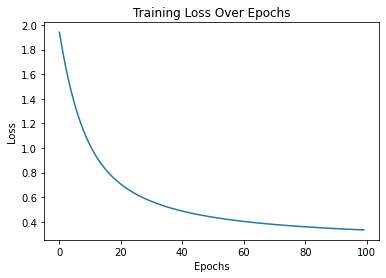

In [269]:
# 손실 기록 리스트
loss_history = []


# CBOW 모델 정의
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context):
        embedded = self.embeddings(context)
        summed = torch.sum(embedded, dim=1)
        output = self.linear(summed)
        return output

# Hyperparameters
vocab_size = len(np.unique(corpus))
embedding_dim = 50
learning_rate = 0.01
epochs = 100

# 모델 초기화
cbow_model = CBOWModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)

# 훈련
for epoch in range(epochs):
    inputs = torch.tensor(contexts, dtype=torch.long)
    labels = torch.tensor(target, dtype=torch.long)

    optimizer.zero_grad()
    outputs = cbow_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 예측
with torch.no_grad():
    test_context = torch.tensor(contexts[0], dtype=torch.long).unsqueeze(0)
    predicted = cbow_model(test_context).argmax(dim=1).item()
    print(f'Predicted: {predicted}, Actual: {target[0]}')

# 손실 그래프 시각화
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

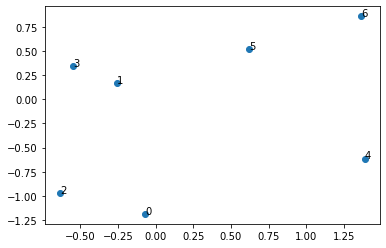

In [257]:
# 단어 임베딩 추출
word_embeddings = cbow_model.embeddings.weight.data.numpy()

# 시각화
for i, word in enumerate(np.unique(corpus)):
    plt.annotate(word, (word_embeddings[i, 0], word_embeddings[i, 1]))

plt.scatter(word_embeddings[:, 0], word_embeddings[:, 1])
plt.show()

Epoch [10/100], Loss: 1.0467
Epoch [20/100], Loss: 0.9720
Epoch [30/100], Loss: 0.9483
Epoch [40/100], Loss: 0.9372
Epoch [50/100], Loss: 0.9307
Epoch [60/100], Loss: 0.9264
Epoch [70/100], Loss: 0.9233
Epoch [80/100], Loss: 0.9209
Epoch [90/100], Loss: 0.9191
Epoch [100/100], Loss: 0.9175
Predicted: 4, Actual: 1


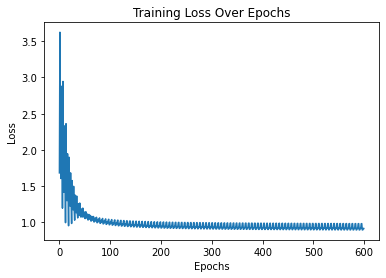

In [270]:
# 손실 기록 리스트
Skip_loss_history = []

# Skip-gram 모델 정의
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target):
        embedded = self.embeddings(target)
        output = self.linear(embedded)
        return output

# Hyperparameters
vocab_size = len(np.unique(corpus))
embedding_dim = 50
learning_rate = 0.01
epochs = 100

# 모델 초기화
skipgram_model = SkipGramModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)

# 훈련
for epoch in range(epochs):
    for target, context in zip(targets, contexts):
        for ctx in context:
            target_tensor = torch.tensor([target], dtype=torch.long)
            context_tensor = torch.tensor([ctx], dtype=torch.long)

            optimizer.zero_grad()
            outputs = skipgram_model(target_tensor)
            loss = criterion(outputs, context_tensor)
            loss.backward()
            optimizer.step()
            Skip_loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 예측
with torch.no_grad():
    test_target = torch.tensor([targets[-1]], dtype=torch.long)  # 마지막 target을 사용
    predicted = skipgram_model(test_target).argmax(dim=1).item()
    print(f'Predicted: {predicted}, Actual: {contexts[-1][0]}')
    
# 손실 그래프 시각화
plt.plot(Skip_loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()